## Installation - Loading the Gymnasium custom environment: LifeSim

Since we're using a custom environment, we need to install its package into the pip environment, such that it will be usable from the gymnasium library. The following code is based on a Google Colab's run.

In [1]:
'''
# %%capture
#!rm -rf /content/gym_projects
!unzip - o / content/archive.zip
!pip uninstall - -no-input life-sim
!pip install - -no-input - e / content/gym_projects/
'''

'\n# %%capture\n#!rm -rf /content/gym_projects\n!unzip - o / content/archive.zip\n!pip uninstall - -no-input life-sim\n!pip install - -no-input - e / content/gym_projects/\n'

If the environment cannot be made with gymnasium.make(), it may be useful to restart the runtime.

In [2]:
'''
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()
'''


'\nimport os\n\ndef restart_runtime():\n  os.kill(os.getpid(), 9)\n\nrestart_runtime()\n'

## Creating the environment

In [3]:
import gymnasium as gym
import gymnasium.vector
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import initializers
from collections import deque
import random
from life_sim.envs import LifeSim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from agent import DQN_Agent, Agent, PPO_Agent
from tensorflow import GradientTape
import memory

2023-06-15 11:06:22.868679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 11:06:23.535482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Adding some useful settings and dictionaries to ease the code

In [4]:
# numpy settings for printing the states, if needed
np.set_printoptions(precision=2)

# some useful dictionaries used to let the code be more readable
# and less error-prone
num_actions = 3

actions = {
    "work": 0,
    "sport": 1,
    "sociality": 2
}

actions_array = {
    0: np.transpose([1, 0, 0]),
    1: np.transpose([0, 1, 0]),
    2: np.transpose([0, 0, 1]),
}

state_map = {
    "money": 0,
    "health": 1,
    "work development": 2,
    "social development": 3,
}

In [5]:
input_shape = [4]
n_outputs = 3
discount_factor = 0.95
'''
optimizer = keras.optimizers.AdamW(learning_rate=0.0006)
loss_fn = keras.losses.mean_squared_error

# create the agent
dqn_agent = DQN_Agent(input_shape, n_outputs, optimizer,
                      loss_fn, discount_factor)

batch_size = 32
replay_buffer = deque(maxlen=10000)
'''

'\noptimizer = keras.optimizers.AdamW(learning_rate=0.0006)\nloss_fn = keras.losses.mean_squared_error\n\n# create the agent\ndqn_agent = DQN_Agent(input_shape, n_outputs, optimizer,\n                      loss_fn, discount_factor)\n\nbatch_size = 32\nreplay_buffer = deque(maxlen=10000)\n'

### Utils

In [6]:
def plot_results(observations, rewards):
    # Plotting the first set of data
    performances = np.transpose(observations)
    plt.figure(1)
    plt.plot(performances[state_map['money']], label='Money')
    plt.plot(performances[state_map['health']], label='Health')
    plt.plot(performances[state_map['work development']],
             label='Work Development')
    plt.plot(performances[state_map['social development']],
             label='Social Development')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('State plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Rewards plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(3)
    plt.plot(np.cumsum(rewards), label='Cumulative Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Cumulative reward plot')
    plt.legend()

    # Displaying the plots
    plt.show()


In [7]:
def training_results(rewards, actions, normalize=False):
    # Normalize the data
    actions = np.transpose(actions)

    if normalize:
        f = np.max(rewards)
        rewards = [r/f for r in rewards]
        f = np.max([np.max(actions[i]) for i in range(len(actions))])
        actions = [[a/f for a in actions[i]] for i in range(len(actions))]

    # Plotting the first set of data
    plt.figure(1)
    plt.plot(actions[0], label='Work')
    plt.plot(actions[1], label='Sport')
    plt.plot(actions[2], label='Sociality')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(actions[0]), 1))
    plt.title('# of Actions, per training step')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Cumulative Reward')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(rewards), 1))
    plt.title('Cumulative Rewards plot, per training step')
    plt.legend()

    # Displaying the plots
    plt.show()


In [8]:
def plot_losses(actor_loss, critic_loss):

    plt.figure(1)
    plt.plot(actor_loss, label='Mean Actor Loss per Epoch')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(1,len(actor_loss),1))
    plt.ylabel('Mean loss')
    plt.yscale('log')
    plt.title('Actor Loss Plot')
    plt.legend()

    plt.figure(2)
    plt.plot(critic_loss, label='Mean Critic Loss per Epoch')
    plt.xlabel('Epochs')
    plt.yscale('log')
    plt.xticks(np.arange(1,len(critic_loss),1))
    plt.ylabel('Mean loss')
    plt.title('Critic Loss Plot')
    plt.legend()

    # Displaying the plots
    plt.show()


### Training the Agent

In [9]:
def training_step(agent: Agent, batch_size):

    loss = agent.train(replay_buffer, batch_size)
    return loss


def add_cumulative_reward(cumulative_rewards, avg_sum_reward, sum_rewards, tau):

    avg_sum_reward = (avg_sum_reward*(tau - 1) + sum_rewards)/tau
    cumulative_rewards.append(avg_sum_reward)


def add_sum_action(sum_actions, avg_sum_actions, actions, tau):

    avg_sum_actions = (np.dot(avg_sum_actions, (tau - 1)) + actions)/tau
    sum_actions.append(avg_sum_actions)


def calc_epsilon(episode, n_episodes, decay):
    return max(1 - episode/(n_episodes*decay), 0.05)


In [10]:
def play_one_step(vec_env, v_actions, epsilon):

    next_states, rewards, terminateds, truncateds, infos = vec_env.step(v_actions)
    return next_states, rewards, terminateds, truncateds, infos, v_actions


In [11]:
def play_episodes(n_episodes, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    for episode in tqdm(np.arange(1, n_episodes, 1), desc="Episodes", position=0):

        sum_rewards = 0
        actions = np.transpose([0, 0, 0])

        v_obs, v_info = vec_env.reset()

        for step in np.arange(1, max_steps, 1):

            epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

            actions = [dqn_agent.predict(o, 0.5) for o in obs]

            v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(
                vec_env, actions, epsilon)
            [replay_buffer.append((v_obs[i], v_action[i], v_reward[i],
                                  v_new_obs[i], v_terminated[i])) for i in range(len(obs))]

            sum_rewards = sum_rewards + np.sum(v_reward)
            actions = actions + actions_array[v_info['last_action']]

            []
            # env.render()
            # if terminated or truncated:
            #    break

        if episode % tau == 0:

            add_cumulative_reward(cumulative_rewards,
                                  avg_sum_reward, sum_rewards, tau)
            add_sum_action(sum_actions, avg_sum_actions, actions, tau)
        else:

            avg_sum_reward = (avg_sum_reward*(episode %
                              tau - 1) + sum_rewards)/(episode % tau)
            avg_sum_actions = (
                np.dot(avg_sum_actions, (episode % tau - 1)) + actions)/(episode % tau)

            if episode > 10 and episode % tau == 0:
                training_step(dqn_agent, batch_size)

    return cumulative_rewards, sum_actions


In [12]:
def play_steps(vec_env, max_steps, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    steps = 0

    v_obs, v_info = vec_env.reset(seed=seeds)

    sum_rewards = 0
    actions = np.transpose([0, 0, 0])


    for steps in tqdm(np.arange(1, max_steps, 1), desc="Steps", position=0):

        epsilon = calc_epsilon(steps, max_steps, decay=0.8)
        v_actions = np.array([dqn_agent.predict(o, 0) for o in v_obs])
        #v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)
        v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)

        # save in buffer for the resetted envs
        # different code because of the vec_env.step() behaviour in case of truncated or terminated episode
        resetted_envs = [i for i in range(len(v_truncated)) if v_truncated[i] or v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_info['final_observation'][i], v_terminated[i]) for i in resetted_envs])

        # save in buffer
        not_resetted_envs = [i for i in range(len(v_truncated)) if not v_truncated[i] and not v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_new_obs[i], v_terminated[i]) for i in not_resetted_envs])

        #sum_rewards = sum_rewards + np.sum(v_reward)
        #actions = actions + \
        #    actions_array[np.sum(v_info['last_action'], axis=1)]

        if steps % tau == 0:
            training_step(dqn_agent, batch_size)

    
    return cumulative_rewards, sum_actions


In [13]:
def calc_adv_list(T, t, rewards, values, gamma, lmbda, terminated, truncated, next_val):
    r = []

    # calculating the t(th) factor
    #done = terminated[T+1] + truncated[T+1]
    # should have nextval...
    
    p = rewards[T] + gamma*next_val - values[T]

    calc_delta_list_r(T-1, t, rewards, values, gamma, lmbda, terminated, truncated, p, r)
    r.append(p)
    return r
    
def calc_delta_list_r(T, t, rewards, values, gamma, lmbda, terminated, truncated, p, r):
    # calculating the t(th) factor
    done = 1- (terminated[T+1] + truncated[T+1])
    p = p*gamma*lmbda + rewards[T] + gamma*values[T + 1]*done - values[T]

    if T == t:
        r.append(p)
        return p
    else:
        calc_delta_list_r(T-1, t, rewards, values, gamma, lmbda, terminated, truncated, p, r)
        r.append(p)
        return p

def calc_returns(T, t, rewards, gamma, terminated, truncated):
    r = []

    # calculating the t(th) factor
    #done = terminated[T+1] + truncated[T+1]
    # should have nextval...
    
    p = rewards[T]

    calc_returns_r(T-1, t, rewards, gamma, terminated, truncated, p, r)
    r.append(p)
    return r
    
def calc_returns_r(T, t, rewards, gamma, terminated, truncated, p, r):
    # calculating the t(th) factor
    done = 1- (terminated[T] + truncated[T])
    p = p*gamma*done + rewards[T]

    if T == t:
        r.append(p)
        return p
    else:
        calc_returns_r(T-1, t, rewards, gamma, terminated, truncated, p, r)
        r.append(p)
        return p


In [14]:
@tf.function
def train_step_ppo(mb_obs, mb_probs, mb_adv, mb_returns, ppo_agent, epsilon, optimizer_actor, optimizer_critic):

    with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
            
        _, new_probs = ppo_agent.get_action(mb_obs)
        new_value = ppo_agent.get_value(mb_obs)

        #new_probs = get_prob_from_action(new_probs, mb_action)

        ratio = tf.divide(new_probs, mb_probs)
        
        clip = tf.clip_by_value(ratio, 1-epsilon, 1+epsilon) * mb_adv
        loss_clip = tf.minimum(ratio * mb_adv, clip)
        loss_clip = -tf.reduce_mean(loss_clip)
        #loss_clip = tf.reduce_mean(loss_clip)
        
        #loss_value = tf.reduce_mean(tf.pow(new_value - mb_returns, 2))
        loss_value = tf.keras.losses.mse(mb_returns, new_value)

        #loss = - loss_clip - loss_value

    grads_actor = tape_actor.gradient(loss_clip, ppo_agent.actor.trainable_variables)
    grads_critic = tape_critic.gradient(loss_value, ppo_agent.critic.trainable_variables)
    optimizer_actor.apply_gradients(zip(grads_actor, ppo_agent.actor.trainable_variables))
    optimizer_critic.apply_gradients(zip(grads_critic, ppo_agent.critic.trainable_variables))
    return loss_clip, loss_value

In [15]:
'''
from tensorflow.compat import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
'''

'\nfrom tensorflow.compat import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.2\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)\n'

In [16]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300
num_envs = 4
seeds = [int(x) for x in np.random.randint(1, 100000 + 1, size=num_envs)]

# create the vectorized environment
vec_env = gymnasium.vector.make(
    'life_sim/LifeSim-v0', num_envs=num_envs, asynchronous=True)
#vec_env = gymnasium.vector.make(
#    'CartPole-v0', num_envs=num_envs, asynchronous=True)

In [17]:
input_shape = vec_env.single_observation_space.shape
#input_shape = [vec_env.single_observation_space.shape[0]]
n_outputs = vec_env.single_action_space.n

In [ ]:
num_steps = 10000
gamma = 0.99
lmbda = 0.95

lr = 1e-3

ppo_critic_optimizer = keras.optimizers.AdamW(learning_rate=lr)
ppo_actor_optimizer = keras.optimizers.AdamW(learning_rate=lr)
actor_loss_fn = tf.losses.mse()
critic_loss_fn = tf.losses.mse()

m = memory.Memory(num_envs = num_envs, obs_shape = vec_env.single_observation_space.shape, timesteps = num_steps)

ppo_agent = PPO_Agent(m, input_shape, n_outputs, gamma, lmbda, ppo_actor_optimizer, ppo_critic_optimizer, )

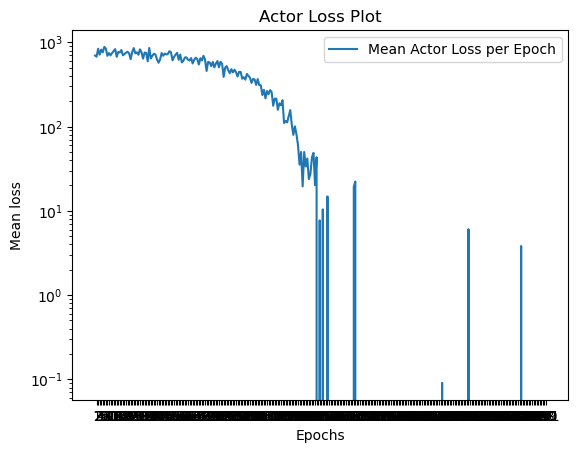

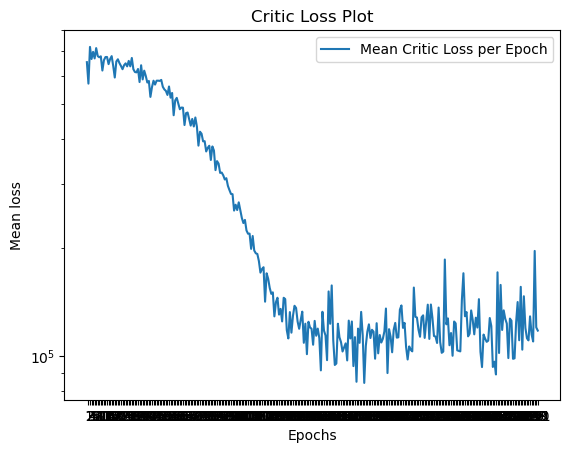

In [ ]:
plot_losses(mean_losses_actor, mean_losses_critic)

In [ ]:
np.max(b_reward)

4.476190567016602

In [ ]:
#calc_returns(5-1, 0, [0,1,1,0,3], 1, [0,0,1,0,0], np.zeros(shape=(5)))

In [ ]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
max_steps = 300

# create the vectorized environment
env = gymnasium.make('life_sim/LifeSim-v0')

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 50

for episode in tqdm(np.arange(1, n_episodes, 1), desc="Episodes", position=0):

    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    for step in np.arange(1, max_steps, 1):
        
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action, _ = ppo_agent.get_action(obs[np.newaxis])

        action = tf.squeeze(action).numpy()
        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards = sum_rewards + reward
#        actions = actions + actions_array[v_info['last_action']]

        # env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)

Episodes:   0%|          | 0/49 [00:00<?, ?it/s]

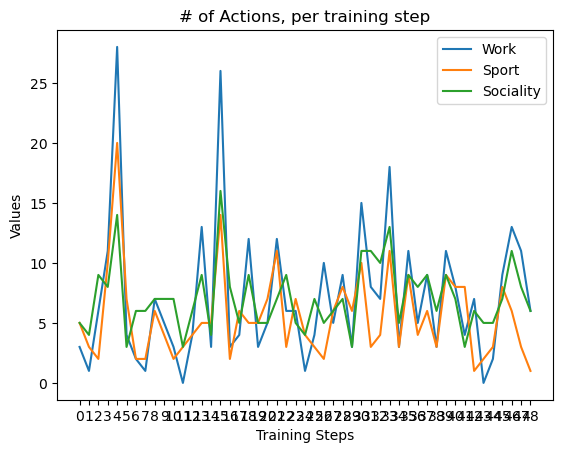

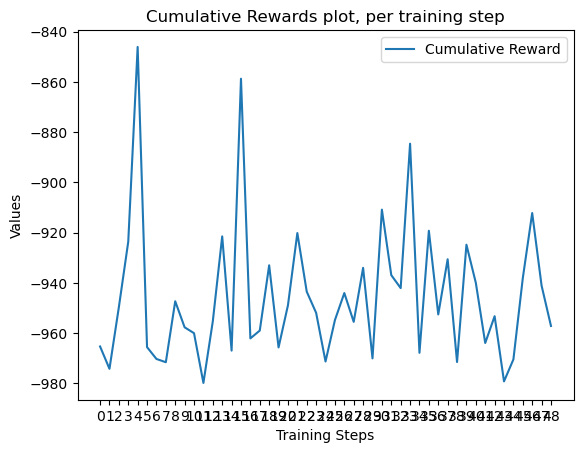

In [ ]:
training_results(cumulative_rewards, sum_actions)

In [ ]:
tau = 100
max_steps = 1585

cumulative_rewards, sum_actions = play_steps(vec_env, max_steps, tau)


Steps:   0%|          | 0/1584 [00:00<?, ?it/s]

AttributeError: module 'tensorflow' has no attribute 'arg'

In [ ]:
len(replay_buffer)

1584

In [ ]:
training_results(cumulative_rewards, sum_actions, normalize=True)


ValueError: zero-size array to reduction operation maximum which has no identity

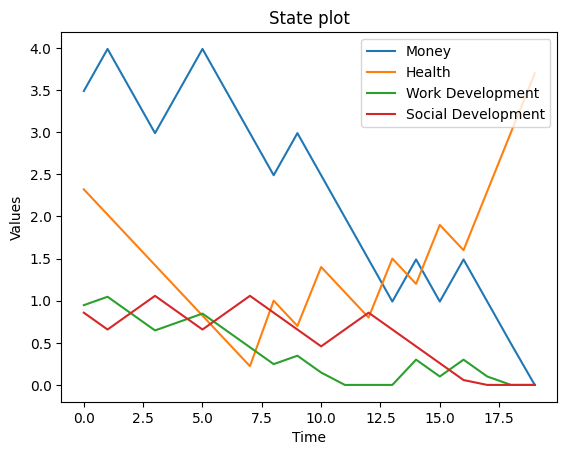

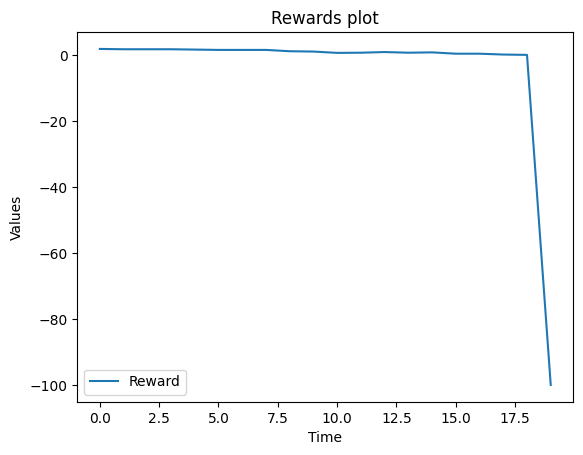

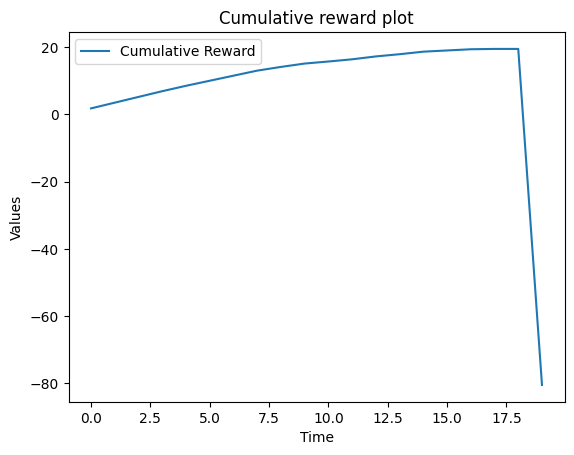

In [ ]:
observations = []
rewards = []

obs, info = env.reset()

done = False
terminated = False
while not done and not terminated:
    obs, reward, terminated, truncated, info = env.step(np.random.randint(3))
    # print(np.array2string(obs))
    observations.append(obs)
    # print(np.array2string(reward))
    rewards.append(reward)
    if terminated or truncated:
        break

plot_results(observations, rewards)


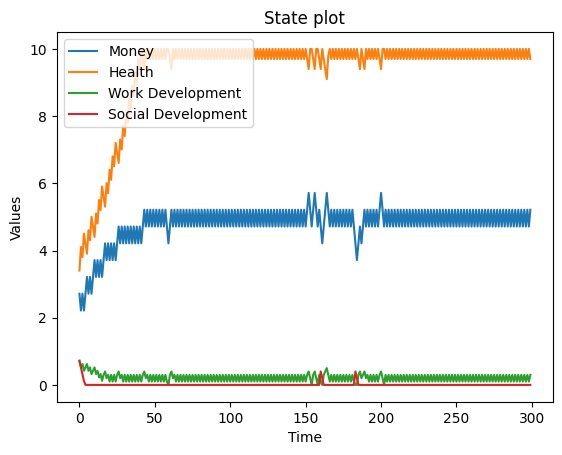

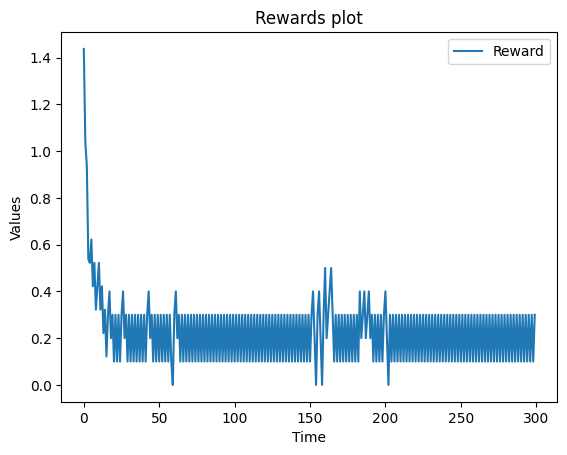

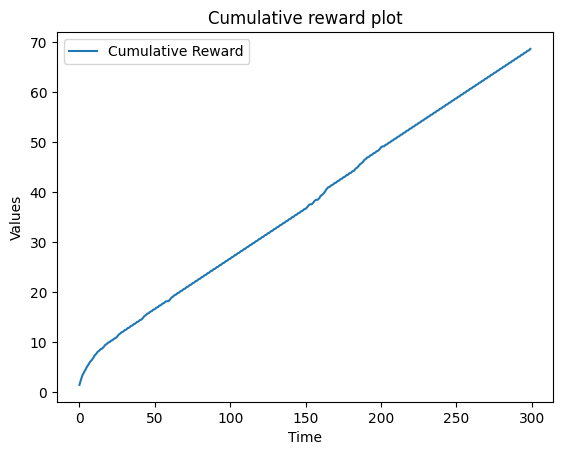

In [ ]:
observations = []
rewards = []

for episode in range(1):

    obs, info = env.reset()
    for step in range(1000):
        epsilon = 0.05
        obs, reward, terminated, truncated, info, action = dqn_agent.play_one_step(
            env, obs, epsilon)
        observations.append(obs)
        rewards.append(reward)
        # env.render()
        if terminated or truncated:
            break

plot_results(observations, rewards)
